# Gender Classification

This notebook will attempt to classify photos of people to determine whether they are male or female 

## Data Input & Cleaning


In [2]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA

train_images_path = "Face Database/TrainImages"
test_images_path = "Face Database/TestImages"

### Image pre-processing (optional PCA)

https://towardsdatascience.com/dimensionality-reduction-does-pca-really-improve-classification-outcome-6e9ba21f0a32


In [6]:
# PCA down-sizing (optional)
is_pca_enabled = True
num_principal_components = 60

def extract_train_test_images(pca_enabled, num_components):
    # Extract gray images from files
    training_images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY) for file in glob.glob("{0}/*.jpg".format(train_images_path))]
    testing_images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY) for file in glob.glob("{0}/*.jpg".format(test_images_path))]
    
    pca = PCA(num_components)
    if (pca_enabled):
        training_images = [pca.inverse_transform(pca.fit_transform(img)) for img in training_images]
        testing_images = [pca.inverse_transform(pca.fit_transform(img)) for img in testing_images]

    # Ensure image sizes are of the same dimension
    # May result loss in accuracy, how to better handle this?
    training_images = [img[:101, :101].reshape(101 * 101) if img.shape != (101, 101) else img.reshape(101 * 101) for img in training_images]
    testing_images = [img[:101, :101].reshape(101 * 101) if img.shape != (101, 101) else img.reshape(101 * 101) for img in testing_images]

    # Convert list to 2d ndarray
    training_images = np.stack(training_images)
    testing_images = np.stack(testing_images)
    
    return (training_images, testing_images)

train_images, test_images = extract_train_test_images(is_pca_enabled, num_principal_components)

In [7]:
# Read ground-truth label
def extract_gender_classifier(file_name):
    file = open(file_name, "r")
    if file.mode == "r":
        contents = file.readlines()
        # Gender label in the 0th index (male: 1; female: 0)
        gender_classifier_str = contents[0]
        return int(gender_classifier_str[0])
    
train_images_label = [extract_gender_classifier(file) for file in glob.glob("{0}/*.att".format(train_images_path))]
test_images_label = np.array([extract_gender_classifier(file) for file in glob.glob("{0}/*.att".format(test_images_path))])

## Rosenblatt's perceptron implementation

In [8]:
# Non-linear activiation function
def heaviside(x):
    return np.heaviside(x, 1).astype(np.int)


threshold = 0.001

class Rosenblatt(BaseEstimator, ClassifierMixin):
    def __init__(self):
        return
    
    def predict(self, X):
        return heaviside(X.dot(self.weights) + self.bias)
    
    """
    Input: 
    
    X: numpy 2D array. Each row represents one training example.
    y: numpy 1D array. Binary classification of each example.
    
    --------
    
    Output:
    
    self: Trained perceptron model
    
    """
    def fit(self, X, y, epochs=100):
        num_features = X.shape[1]
    
        self.weights = np.zeros((num_features, ))
        self.bias = 0.0
        
        for num_iter in range(epochs):
            # Current number of errors
            errors = 0
            
            for xi, y_true in zip(X, y):
                error = y_true - self.predict(xi)
                
                if abs(error) > threshold:
                    # Update weights accordingly
                    self.weights += error * xi
                    self.bias += error
                    
                    # Number of errors
                    errors += 1
            
            if errors == 0:
                break

        return self

### Training and testing Rosenblatt's perceptron

In [9]:
# Training and running model against train data
model = Rosenblatt()
model.fit(train_images, train_images_label)
test_images_output = model.predict(test_images)

### Checking accuracy of Rosenblatt's perceptron model

In [10]:
# Rosenblatt's perceptron accuracy rate
num_correct = np.where(test_images_output == test_images_label)[0].shape[0]

accuracy = num_correct / test_images_label.shape[0]

print("Accuracy: {0}%".format(accuracy * 100))

66.4


### Compare accuracy between different number of principal components


Number of PCA components: 1; Time taken: 7.778629779815674; Accuracy rate: 56.39999999999999%
Number of PCA components: 6; Time taken: 8.38592004776001; Accuracy rate: 72.0%
Number of PCA components: 11; Time taken: 7.053526163101196; Accuracy rate: 70.39999999999999%
Number of PCA components: 16; Time taken: 7.246672868728638; Accuracy rate: 70.8%
Number of PCA components: 21; Time taken: 7.060499906539917; Accuracy rate: 71.2%
Number of PCA components: 26; Time taken: 7.972759008407593; Accuracy rate: 69.19999999999999%
Number of PCA components: 31; Time taken: 7.987107038497925; Accuracy rate: 73.6%
Number of PCA components: 36; Time taken: 7.919018983840942; Accuracy rate: 61.199999999999996%
Number of PCA components: 41; Time taken: 10.805781126022339; Accuracy rate: 63.6%
Number of PCA components: 46; Time taken: 9.346468210220337; Accuracy rate: 70.0%
Number of PCA components: 51; Time taken: 8.084949970245361; Accuracy rate: 64.8%
Number of PCA components: 56; Time taken: 8.583

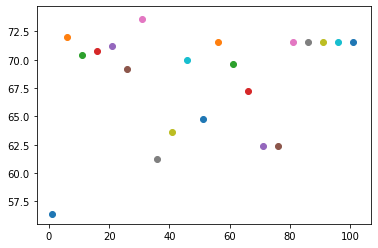

In [16]:
for num_principal_components in range(1, 102, 5):
    start_time = time.time()
    train_images, test_images = extract_train_test_images(True, num_principal_components)
    
    model = Rosenblatt()
    model.fit(train_images, train_images_label)
    test_images_output = model.predict(test_images)
    
    # Rosenblatt's perceptron accuracy rate
    num_correct = np.where(test_images_output == test_images_label)[0].shape[0]

    accuracy = num_correct / test_images_label.shape[0] * 100
    
    elapsed_time = time.time() - start_time
    plt.scatter(num_principal_components, accuracy)
    print("Number of PCA components: {0}; Time taken: {1}; Accuracy rate: {2}%".format(num_principal_components, elapsed_time, accuracy))
    
plt.show()

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/


https://www.askpython.com/python/examples/principal-component-analysis-for-image-data



## PCA image compression

Testing out here and there

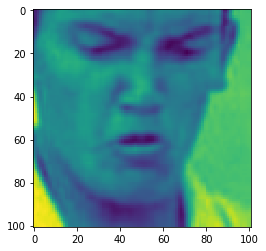

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread("Face Database/TrainImages/Abel_Aguilar_0001.jpg"), cv2.COLOR_BGR2GRAY)

pca = PCA(20)
img_compressed = pca.inverse_transform(pca.fit_transform(img))
plt.imshow(img_compressed)

### Batch & Sequential Mode training with Keras

In [83]:
import tensorflow as tf

train_images, test_images = extract_train_test_images(False, num_principal_components)
train_images_label = np.array([extract_gender_classifier(file) for file in glob.glob("{0}/*.att".format(train_images_path))])
test_images_label = np.array([extract_gender_classifier(file) for file in glob.glob("{0}/*.att".format(test_images_path))])

In [84]:
model = tf.keras.models.Sequential()

# Layer building
model.add(tf.keras.layers.Dense(256, input_dim=10201, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# Output layer (number of classifications)
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
# Sequential Training
is_sequential = False
batch_size = 1 if is_sequential else train_images.shape[0]
    
model.fit(x=train_images, y=train_images_label, epochs=150, batch_size=batch_size)

Epoch 1/150
1/1 [==============================] - 0s 90ms/step - loss: 2.6990 - accuracy: 0.3350
Epoch 2/150
1/1 [==============================] - 0s 61ms/step - loss: 3.5345 - accuracy: 0.7400
Epoch 3/150
1/1 [==============================] - 0s 65ms/step - loss: 4.3225 - accuracy: 0.7400
Epoch 4/150
1/1 [==============================] - 0s 62ms/step - loss: 1.6571 - accuracy: 0.7410
Epoch 5/150
1/1 [==============================] - 0s 65ms/step - loss: 9.0765 - accuracy: 0.2610
Epoch 6/150
1/1 [==============================] - 0s 63ms/step - loss: 1.4481 - accuracy: 0.7410
Epoch 7/150
1/1 [==============================] - 0s 64ms/step - loss: 3.3303 - accuracy: 0.7400
Epoch 8/150
1/1 [==============================] - 0s 70ms/step - loss: 1.9698 - accuracy: 0.7460
Epoch 9/150
1/1 [==============================] - 0s 72ms/step - loss: 4.8274 - accuracy: 0.2820
Epoch 10/150
1/1 [==============================] - 0s 79ms/step - loss: 2.7196 - accuracy: 0.7420
Epoch 11/150
1/1 [=

1/1 [==============================] - 0s 67ms/step - loss: 1.0022 - accuracy: 0.7410
Epoch 84/150
1/1 [==============================] - 0s 72ms/step - loss: 0.7132 - accuracy: 0.7490
Epoch 85/150
1/1 [==============================] - 0s 61ms/step - loss: 1.4706 - accuracy: 0.4540
Epoch 86/150
1/1 [==============================] - 0s 62ms/step - loss: 2.0031 - accuracy: 0.7400
Epoch 87/150
1/1 [==============================] - 0s 63ms/step - loss: 2.3143 - accuracy: 0.7400
Epoch 88/150
1/1 [==============================] - 0s 64ms/step - loss: 0.7086 - accuracy: 0.7480
Epoch 89/150
1/1 [==============================] - 0s 62ms/step - loss: 4.5182 - accuracy: 0.2940
Epoch 90/150
1/1 [==============================] - 0s 63ms/step - loss: 1.5939 - accuracy: 0.7410
Epoch 91/150
1/1 [==============================] - 0s 82ms/step - loss: 2.7924 - accuracy: 0.7390
Epoch 92/150
1/1 [==============================] - 0s 69ms/step - loss: 1.6868 - accuracy: 0.7410
Epoch 93/150
1/1 [=====

In [86]:
# Testing (Evaluate model)
_, accuracy = model.evaluate(x=test_images, y=test_images_label)

8/8 [==============================] - 0s 3ms/step - loss: 9.1991 - accuracy: 0.7360
